# CIFAR examples

This code runs CIFAR10 and CIFAR100. To switch between these two datasets, update the `dataset` field in `train_config.yaml` and the `data_path` field in `audit.yaml` accordingly.


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [2]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)
    
root = train_config["data"]["data_dir"]
path = os.path.join(os.getcwd(), root)
# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=root, train=True, download=True)
    testset = CIFAR10(root=root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=root, train=True, download=True)
    testset = CIFAR100(root=root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro
dataset_name = train_config["data"]["dataset"]
file_path =  "data/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

# Evaluate mean and variance of the train data
train_mean = train_subset.mean
train_std = train_subset.std
print (f"Train mean: {train_mean}, Train std: {train_std}")

Train mean: tensor([[[0.4919]],

        [[0.4831]],

        [[0.4478]]]), Train std: tensor([[[0.2470]],

        [[0.2433]],

        [[0.2614]]])



With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [5]:
from torch import save, optim, nn
from cifar_handler import CifarInputHandler
from target_model_class import ResNet18, WideResNet

# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Create instance of target model
#model = ResNet18(num_classes = num_classes)
model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
weight_decay = train_config["train"]["weight_decay"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# train target model
train_result = CifarInputHandler().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)

# Evaluate on test set
test_result = CifarInputHandler().eval(test_loader, model, criterion)

# Store the model and metadata
model = train_result.model
model.to("cpu")
with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open("target/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)
    

Epoch 1/25: 100%|██████████| 106/106 [00:08<00:00, 11.82it/s, acc=0.1689, loss=2.3447]


Validation loss at epoch 1: 2.2780


Epoch 2/25: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.2905, loss=1.8867]


Validation loss at epoch 2: 3.6913


Epoch 3/25: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.3634, loss=1.6998]


Validation loss at epoch 3: 2.9094


Epoch 4/25: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.4190, loss=1.5573]


Validation loss at epoch 4: 2.2933


Epoch 5/25: 100%|██████████| 106/106 [00:08<00:00, 12.56it/s, acc=0.4546, loss=1.4732]


Validation loss at epoch 5: 13.0586


Epoch 6/25: 100%|██████████| 106/106 [00:08<00:00, 12.60it/s, acc=0.4824, loss=1.4069]


Validation loss at epoch 6: 4.8180


Epoch 7/25: 100%|██████████| 106/106 [00:08<00:00, 12.96it/s, acc=0.5063, loss=1.3509]


Validation loss at epoch 7: 3.5545


Epoch 8/25: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=0.5213, loss=1.3062]


Validation loss at epoch 8: 2.1842


Epoch 9/25: 100%|██████████| 106/106 [00:08<00:00, 12.94it/s, acc=0.5343, loss=1.2792]


Validation loss at epoch 9: 1.9874


Epoch 10/25: 100%|██████████| 106/106 [00:08<00:00, 12.96it/s, acc=0.5476, loss=1.2419]


Validation loss at epoch 10: 2.5187


Epoch 11/25: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=0.5531, loss=1.2259]


Validation loss at epoch 11: 1.7290


Epoch 12/25: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=0.5729, loss=1.1837]


Validation loss at epoch 12: 2.5585


Epoch 13/25: 100%|██████████| 106/106 [00:08<00:00, 12.94it/s, acc=0.5761, loss=1.1759]


Validation loss at epoch 13: 2.9349


Epoch 14/25: 100%|██████████| 106/106 [00:08<00:00, 12.94it/s, acc=0.5833, loss=1.1520]


Validation loss at epoch 14: 3.1329


Epoch 15/25: 100%|██████████| 106/106 [00:08<00:00, 12.60it/s, acc=0.5886, loss=1.1409]


Validation loss at epoch 15: 1.8363


Epoch 16/25: 100%|██████████| 106/106 [00:08<00:00, 12.95it/s, acc=0.6001, loss=1.1066]


Validation loss at epoch 16: 1.7904


Epoch 17/25: 100%|██████████| 106/106 [00:08<00:00, 12.95it/s, acc=0.6116, loss=1.0865]


Validation loss at epoch 17: 2.3373


Epoch 18/25: 100%|██████████| 106/106 [00:08<00:00, 12.97it/s, acc=0.6248, loss=1.0490]


Validation loss at epoch 18: 1.3934


Epoch 19/25: 100%|██████████| 106/106 [00:08<00:00, 12.91it/s, acc=0.6343, loss=1.0263]


Validation loss at epoch 19: 1.5404


Epoch 20/25: 100%|██████████| 106/106 [00:08<00:00, 12.87it/s, acc=0.6437, loss=0.9936]


Validation loss at epoch 20: 1.2609


Epoch 21/25: 100%|██████████| 106/106 [00:08<00:00, 12.95it/s, acc=0.6530, loss=0.9634]


Validation loss at epoch 21: 0.9919


Epoch 22/25: 100%|██████████| 106/106 [00:08<00:00, 12.95it/s, acc=0.6642, loss=0.9365]


Validation loss at epoch 22: 1.1017


Epoch 23/25: 100%|██████████| 106/106 [00:08<00:00, 12.94it/s, acc=0.6771, loss=0.9075]


Validation loss at epoch 23: 1.0559


Epoch 24/25: 100%|██████████| 106/106 [00:08<00:00, 12.90it/s, acc=0.6849, loss=0.8838]


Validation loss at epoch 24: 0.9629


Epoch 25/25: 100%|██████████| 106/106 [00:08<00:00, 12.94it/s, acc=0.6926, loss=0.8645]


Validation loss at epoch 25: 0.9328


Plot accuracy and test of training and test.

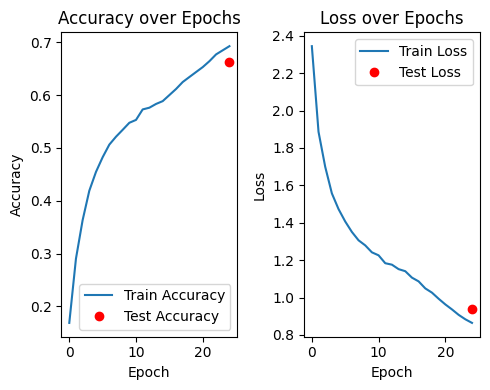

In [6]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Privacy Auditing using LeakPro

1. Create a LeakPro instance by feeding the CIFAR input handler.
2. Run the attacks defined in audit.yaml
    * Attacks are easily added/removed by simply adding to the audit.yaml
3. Obtain the result objects

In [7]:
# Read the config file
config_path = "audit.yaml"
from leakpro import LeakPro
from cifar_handler import CifarInputHandler

# Instantiate leakpro object
leakpro = LeakPro(CifarInputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(create_pdf=True)

2025-10-31 10:15:40,931 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
10/31/2025 10:15:40:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-10-31 10:15:41,013 INFO     Loaded target model metadata from ./target/model_metadata.pkl
10/31/2025 10:15:41:INFO:Loaded target model metadata from ./target/model_metadata.pkl
2025-10-31 10:15:41,095 INFO     Loaded target model from ./target
10/31/2025 10:15:41:INFO:Loaded target model from ./target
2025-10-31 10:15:42,166 INFO     Loaded population dataset from ./data/cifar10.pkl
10/31/2025 10:15:42:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-10-31 10:15:54.325429: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 10:15:55.326643: I te

Validation loss at epoch 1: 3.5359


Epoch 2/25: 100%|██████████| 106/106 [00:08<00:00, 12.95it/s, acc=0.3074, loss=1.8289]


Validation loss at epoch 2: 2.1087


Epoch 3/25: 100%|██████████| 106/106 [00:08<00:00, 12.98it/s, acc=0.3699, loss=1.6609]


Validation loss at epoch 3: 3.1205


Epoch 4/25: 100%|██████████| 106/106 [00:08<00:00, 12.96it/s, acc=0.4111, loss=1.5717]


Validation loss at epoch 4: 3.2373


Epoch 5/25: 100%|██████████| 106/106 [00:08<00:00, 12.83it/s, acc=0.4317, loss=1.5162]


Validation loss at epoch 5: 3.5976


Epoch 6/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.4663, loss=1.4418]


Validation loss at epoch 6: 2.4678


Epoch 7/25: 100%|██████████| 106/106 [00:08<00:00, 12.92it/s, acc=0.4907, loss=1.3851]


Validation loss at epoch 7: 1.8335


Epoch 8/25: 100%|██████████| 106/106 [00:08<00:00, 12.91it/s, acc=0.5018, loss=1.3546]


Validation loss at epoch 8: 2.1279


Epoch 9/25: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.5136, loss=1.3294]


Validation loss at epoch 9: 2.0560


Epoch 10/25: 100%|██████████| 106/106 [00:08<00:00, 12.83it/s, acc=0.5228, loss=1.3140]


Validation loss at epoch 10: 6.2850


Epoch 11/25: 100%|██████████| 106/106 [00:08<00:00, 12.93it/s, acc=0.5217, loss=1.3021]


Validation loss at epoch 11: 2.4666


Epoch 12/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.5290, loss=1.2793]


Validation loss at epoch 12: 2.3005


Epoch 13/25: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.5340, loss=1.2728]


Validation loss at epoch 13: 1.9454


Epoch 14/25: 100%|██████████| 106/106 [00:08<00:00, 12.91it/s, acc=0.5436, loss=1.2523]


Validation loss at epoch 14: 2.7210


Epoch 15/25: 100%|██████████| 106/106 [00:08<00:00, 12.87it/s, acc=0.5488, loss=1.2424]


Validation loss at epoch 15: 12.8482


Epoch 16/25: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.5525, loss=1.2271]


Validation loss at epoch 16: 2.0227


Epoch 17/25: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=0.5633, loss=1.1972]


Validation loss at epoch 17: 1.4644


Epoch 18/25: 100%|██████████| 106/106 [00:08<00:00, 12.92it/s, acc=0.5695, loss=1.1829]


Validation loss at epoch 18: 1.9366


Epoch 19/25: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=0.5794, loss=1.1516]


Validation loss at epoch 19: 1.2059


Epoch 20/25: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.5864, loss=1.1367]


Validation loss at epoch 20: 1.4793


Epoch 21/25: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.5998, loss=1.1128]


Validation loss at epoch 21: 1.1557


Epoch 22/25: 100%|██████████| 106/106 [00:08<00:00, 12.87it/s, acc=0.6084, loss=1.0810]


Validation loss at epoch 22: 1.1401


Epoch 23/25: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=0.6152, loss=1.0628]


Validation loss at epoch 23: 1.1346


Epoch 24/25: 100%|██████████| 106/106 [00:08<00:00, 12.92it/s, acc=0.6252, loss=1.0456]


Validation loss at epoch 24: 1.0872


Epoch 25/25: 100%|██████████| 106/106 [00:08<00:00, 12.93it/s, acc=0.6264, loss=1.0351]


Validation loss at epoch 25: 1.0739


2025-10-31 10:19:42,844 INFO     Training shadow model 0 complete
10/31/2025 10:19:42:INFO:Training shadow model 0 complete
2025-10-31 10:19:42,913 INFO     Saved shadow model 0 to ./cifar10/leakpro_output/attack_objects/shadow_model
10/31/2025 10:19:42:INFO:Saved shadow model 0 to ./cifar10/leakpro_output/attack_objects/shadow_model
2025-10-31 10:19:42,914 INFO     Storing metadata for shadow model 0
10/31/2025 10:19:42:INFO:Storing metadata for shadow model 0
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]
2025-10-31 10:19:52,772 INFO     Saved logits to leakpro_output/attack_cache/sm_0_logits.npy
10/31/2025 10:19:52:INFO:Saved logits to leakpro_output/attack_cache/sm_0_logits.npy
2025-10-31 10:19:52,777 INFO     Metadata for shadow model 0:
init_params={'depth': 28, 'num_classes': 10, 'widen_factor': 2, 'dropRate': 0.0} train_indices=[3243, 50541, 16122, 48843, 57593, 45871, 15421, 50910, 6888, 10775, 22811, 153, 31636, 20591, 59240, 57140, 58279, 17446, 53996, 1

Validation loss at epoch 1: 2.9103


Epoch 2/25: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.3190, loss=1.7962]


Validation loss at epoch 2: 2.1258


Epoch 3/25: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=0.3698, loss=1.6684]


Validation loss at epoch 3: 1.9171


Epoch 4/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.4275, loss=1.5309]


Validation loss at epoch 4: 6.7092


Epoch 5/25: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.4570, loss=1.4643]


Validation loss at epoch 5: 3.5742


Epoch 6/25: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.4811, loss=1.4086]


Validation loss at epoch 6: 2.3473


Epoch 7/25: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.5050, loss=1.3518]


Validation loss at epoch 7: 2.4592


Epoch 8/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.5154, loss=1.3153]


Validation loss at epoch 8: 3.1568


Epoch 9/25: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.5212, loss=1.3040]


Validation loss at epoch 9: 3.6895


Epoch 10/25: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.5404, loss=1.2620]


Validation loss at epoch 10: 3.6262


Epoch 11/25: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.5410, loss=1.2592]


Validation loss at epoch 11: 2.6793


Epoch 12/25: 100%|██████████| 106/106 [00:08<00:00, 12.87it/s, acc=0.5494, loss=1.2336]


Validation loss at epoch 12: 2.3405


Epoch 13/25: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=0.5549, loss=1.2220]


Validation loss at epoch 13: 1.6985


Epoch 14/25: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.5715, loss=1.1792]


Validation loss at epoch 14: 2.4324


Epoch 15/25: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.5752, loss=1.1739]


Validation loss at epoch 15: 2.7990


Epoch 16/25: 100%|██████████| 106/106 [00:08<00:00, 12.87it/s, acc=0.5864, loss=1.1438]


Validation loss at epoch 16: 1.3368


Epoch 17/25: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.5954, loss=1.1183]


Validation loss at epoch 17: 1.5133


Epoch 18/25: 100%|██████████| 106/106 [00:08<00:00, 12.89it/s, acc=0.6059, loss=1.0918]


Validation loss at epoch 18: 1.3388


Epoch 19/25: 100%|██████████| 106/106 [00:08<00:00, 12.91it/s, acc=0.6150, loss=1.0653]


Validation loss at epoch 19: 1.9042


Epoch 20/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.6236, loss=1.0419]


Validation loss at epoch 20: 1.5464


Epoch 21/25: 100%|██████████| 106/106 [00:08<00:00, 12.83it/s, acc=0.6343, loss=1.0120]


Validation loss at epoch 21: 1.0837


Epoch 22/25: 100%|██████████| 106/106 [00:08<00:00, 12.90it/s, acc=0.6475, loss=0.9862]


Validation loss at epoch 22: 1.0531


Epoch 23/25: 100%|██████████| 106/106 [00:08<00:00, 12.98it/s, acc=0.6537, loss=0.9652]


Validation loss at epoch 23: 0.9892


Epoch 24/25: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.6604, loss=0.9459]


Validation loss at epoch 24: 0.9750


Epoch 25/25: 100%|██████████| 106/106 [00:08<00:00, 12.91it/s, acc=0.6634, loss=0.9328]


Validation loss at epoch 25: 0.9556


2025-10-31 10:23:29,295 INFO     Training shadow model 1 complete
10/31/2025 10:23:29:INFO:Training shadow model 1 complete
2025-10-31 10:23:29,321 INFO     Saved shadow model 1 to ./cifar10/leakpro_output/attack_objects/shadow_model
10/31/2025 10:23:29:INFO:Saved shadow model 1 to ./cifar10/leakpro_output/attack_objects/shadow_model
2025-10-31 10:23:29,323 INFO     Storing metadata for shadow model 1
10/31/2025 10:23:29:INFO:Storing metadata for shadow model 1
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]
2025-10-31 10:23:39,161 INFO     Saved logits to leakpro_output/attack_cache/sm_1_logits.npy
10/31/2025 10:23:39:INFO:Saved logits to leakpro_output/attack_cache/sm_1_logits.npy
2025-10-31 10:23:39,166 INFO     Metadata for shadow model 1:
init_params={'depth': 28, 'num_classes': 10, 'widen_factor': 2, 'dropRate': 0.0} train_indices=[58454, 35072, 45092, 43211, 32543, 54988, 40639, 23815, 6749, 45660, 26702, 13246, 48104, 47614, 56509, 43210, 13141, 3013, 10454,

<Figure size 640x480 with 0 Axes>